# add a Droupout layer

In [1]:
import pandas as pd
import numpy as np
import keras as kr
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
md_para = pd.read_csv('../data/substituted_benzene_para_md.csv')
md_orth = pd.read_csv('../data/substituted_benzene_orth_md.csv')
md_meta = pd.read_csv('../data/substituted_benzene_meta_md.csv')
md = pd.concat([md_meta,md_orth,md_para],axis=0,join='inner',ignore_index=True)
gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv')
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv')
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv')
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [3]:
result = pd.merge(md, gammadata, on='cindex')
result = result[(result['magnitude_gamma'] < 26000)]
Y = result.iloc[:, -1]
Y = np.array(Y, dtype = np.float32)
Y=(Y-5200)/20800

X = result.iloc[:, 1:-4]
X = X[X.T[X.dtypes!=np.object].index]
X = np.array(X, dtype = np.float32)
st = StandardScaler()
X= st.fit_transform(X)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
model.add(Dense(units = 500, input_dim = X.shape[1], activation='relu'))
model.add(Dense(units=50,activation='relu'))
model.add(Activation('sigmoid'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               643500    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25050     
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 668,601
Trainable params: 668,601
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 400, batch_size = 32,validation_data = (X_test, y_test),verbose=0)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Test loss: 0.019326068460941315
Test accuracy: 0.0
Neural Network RMS 0.2236834556174531


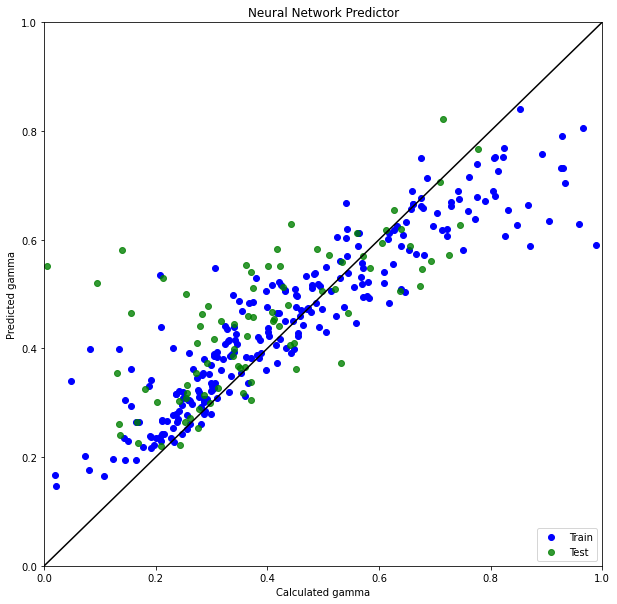

In [6]:
plt.figure(figsize=(10,10))
plt.title('Neural Network Predictor')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Calculated gamma')
plt.ylabel('Predicted gamma')
plt.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
plt.scatter(y_test, model.predict(X_test), c = 'green', label = 'Test', alpha = 0.8)
#plt.hist(Y,bins=10)
plt.plot([0,1],[0,1],c = 'k')
plt.legend(loc = 4)
#plt.savefig('Neural Network Predictor.png', dpi=500)
plt.show()

the value of test loss is little better than ecfp

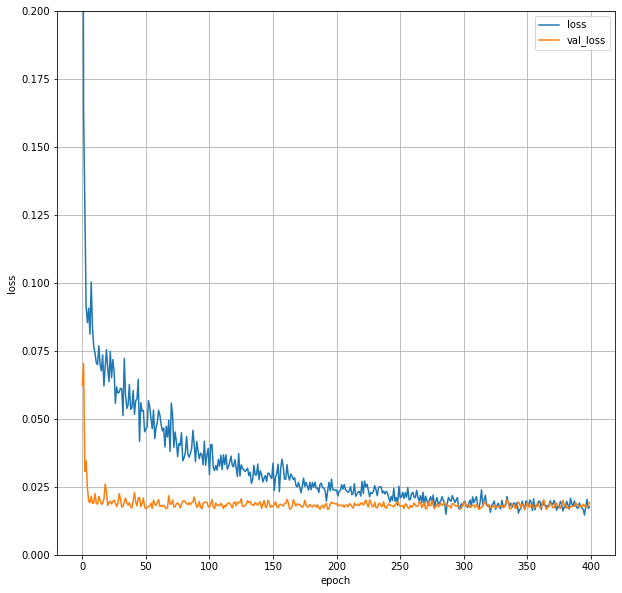

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.figure(figsize=(10,10))
plt.ylim(0,0.2)
plt.plot(range(epochs), loss, label = 'loss')
plt.plot(range(epochs), val_loss, label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig('loss & val_loss for epochs.png', dpi=500)
plt.show()